# Stable Diffusion

#### 학습 목표

> Diffusers에 구현된 Stable Diffusion을 통해 이미지를 생성해보며, Stable Diffusion을 이해한다.
>
> LoRA를 통해 fine-tuning 및 inference을 진행하며, Stable Diffusion의 추가 학습 방법과 LoRA의 구조를 이해한다.

**목차**

1. Stable Diffusion 및 Stable Diffusion XL 사용해보기
2. LoRA를 이용한 Stable Diffusion 학습
3. 사전 학습된 LoRA를 이용한 Stable Diffusion 추론

# Stable Diffusion 이란?

> 최근 AI가 생성했다고 하는 대부분의 이미지들은 Stability AI에서 공개한 Stable Diffusion이라는 모델이거나 이의 변형이다.
> Stable Diffusion은 오픈소스로 공개된 모델이기 때문에 [stablediffusionweb](https://stablediffusionweb.com/), [huggingface](https://huggingface.co/spaces/stabilityai/stable-diffusion) 등의 사이트에서 무료로 웹에서도 사용할 수 있다.
>
> Stable diffusion (SD)은 [LAION 5B](https://laion.ai/blog/laion-5b/)이라는 데이터셋을 활용하였는데 웹에서 크롤링한 이미지와 텍스트 쌍 5B, 즉 50억 쌍을 이용하여 학습한 모델이다.
>
> 이는 일반적인 연구실에서 진행하기 어려운 규모이며, 공개되지 않았던 모델을 제외하면, 기존에 존재하던 어떤 모델보다 높은 성능을 가지고 있다.

![](https://images.squarespace-cdn.com/content/v1/6213c340453c3f502425776e/0715034d-4044-4c55-9131-e4bfd6dd20ca/2_4x.png)

![](https://github.com/Stability-AI/stablediffusion/raw/main/assets/stable-samples/txt2img/768/merged-0002.png)



> Stable Diffusion은 아래 그림과 같이 [LDM](https://arxiv.org/abs/2112.10752)의 구조를 가지고 있다.
>
> LDM 구조의 가장 큰 특징은 이미지를 생성할 때, 픽셀 레벨에서 생성하는 것이 아니라 latent 단계에서 생성하는 것이다.
>
> 이는 계산적으로 엄청난 이점을 가지고 있으며, 이를 통해 학습 역시도 픽셀 단위에서 진행하는 것에 비해 훨씬 효율적이다.

> Stable Diffusion이 차용한 LDM 구조는 앞서 언급한대로 픽셀 레벨에서 latent space로 보내는 encoder-decoder 구조를 가지고 있는데, 이는 모두 Hugging Face에서 만든 Diffusers라는 프레임워크로 구현되어있기 때문에 쉽게 사용할 수 있다.
>
> 아래의 과정들을 따라하며 Stable diffusion이 이미지를 생성하는 과정을 이해해보자.

<img src="https://github.com/CompVis/latent-diffusion/raw/main/assets/modelfigure.png" width="60%">

## 1. `StableDiffusionPipeline` 이용하기


### Setup


> Diffusers 라이브러리와 함께 몇 가지 패키지를 설치해야 한다.
>
> - diffusers
> - transformers
> - accelerate
> - scipy


In [ ]:
!pip install diffusers transformers accelerate scipy
# !git clone https://github.com/huggingface/diffusers  # 또는 이와 같이 editable로 설치할 수 있다.

In [ ]:
import torch
from IPython.display import display

> Stable Diffusion을 다운로드 받아보자!
>
> 다양한 버젼의 Stable diffusion이 있는데 이 중 Stable Diffusion v1-5와 Stable Diffusion XL을 사용해 볼 것이다.
>
> 아래 주석을 바꾸면 다양한 모델을 활용할 수 있습니다.


> 다양한 text-to-image generation model 중 어떤 모델을 선택할지 결정하는 방법 중 하나는 아래 그림과 같은 평가 기준에 따르는 것이다.
>
> 아래 그림은 문자열 반영 정도 (가로축), 이미지 퀄리티 (세로축)으로 이루어져 있다.
>
> 문자열 반영 정도를 나타내는 CLIP Score는 높을수록, 이미지 퀄리티를 나타내는 FID는 낮을수록 좋은 이미지를 생성한다고 볼 수 있다.

> 이 때 diffusion models의 특이한 점은 한 모델 내에서도 문자열 반영 정도와 이미지 퀄리티의 trade-off를 조절할 수 있다는 점인데, 자세한 내용은 [classifier-free guidance](https://arxiv.org/abs/2207.12598) 논문을 참고하자.
>
> Classifier-free guidance의 scale을 조정하면 test-time에 이미 학습된 한 모델 내에서도 다양한 결과를 얻을 수 있다.

<img src="https://github.com/CompVis/stable-diffusion/raw/main/assets/v1-variants-scores.jpg" width="45%">
<img src="https://github.com/Stability-AI/stablediffusion/raw/main/assets/model-variants.jpg" width="45%">

## Stable Diffusion 1.5 (SDv1.5)

> 먼저 Stable Diffusion 1.5를 활용해보자.
>
> 복잡한 옵션들을 활용하지 않고 단순히 text-to-image generation을 수행한다면, 모델을 불러오는 것 외에는 Stable Diffusion 1.5와 Stable Diffusion XL의 사용 방법이 모두 동일하다는 것 역시 확인해 볼 것이다.
>
> 아래 코드를 통해 Stable Diffusion 1.5를 불러올 수 있다.

In [ ]:
from diffusers import StableDiffusionPipeline

# SD-v1-5
model_id = "runwayml/stable-diffusion-v1-5"
# model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

> 이제 아래 `prompt = ...` 자리에 원하는 텍스트를 입력하여 이미지를 생성해보자.
>
> Colab에서는 대략 30초 정도 걸리는데 GPU 환경이 더 좋은 상황이라면 더 빠르게 이미지를 생성할 수 있다.
>
> prompt book을 활용하면 더 좋은 이미지를 생성해 낼 수 있다.
>   - https://openart.ai/promptbook

  0%|          | 0/50 [00:00<?, ?it/s]

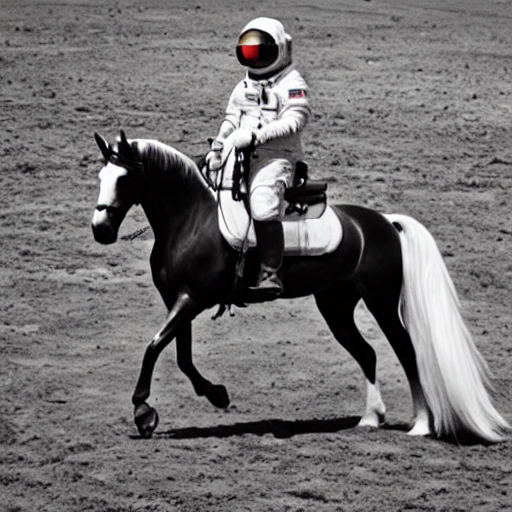

In [ ]:
prompt = "a photograph of an astronaut riding a horse."
image = pipe(prompt, height=512, width=512).images[0]

# image.save("image.png")  # 이미지를 저장하고 싶다면 활용
image

> 기본적으로 매번 생성하면 완전히 다른 이미지가 나오지만 컴퓨터의 모든 randomness를 결정하는 랜덤 시드를 고정하면 항상 같은 이미지가 나온다.
>
> 랜덤시드를 고정한 후에 텍스트를 조금씩 바꾸면 더 쉽게 원하는 사진을 만들 수 있다.

  0%|          | 0/50 [00:00<?, ?it/s]

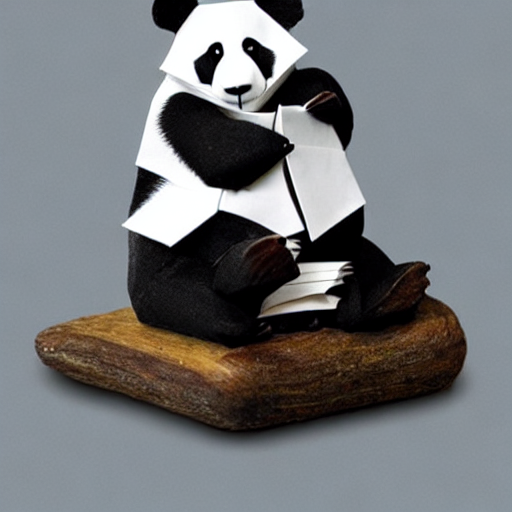

In [ ]:
generator = torch.Generator("cuda").manual_seed(1024)

prompt = "a panda sitting on a desk, origami art"
image = pipe(prompt, generator=generator).images[0]
image

## Stable Diffusion XL (SDXL)

> 이번에는 더 최근에 소개된 Stable Diffusion XL을 활용해보자.

In [ ]:
from diffusers import StableDiffusionXLPipeline
# from diffusers import AutoPipelineForText2Image  # 이것도 가능

# SDXL
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

> 이번에는 `prompt`, `height`, `width` 외에도 `negative_prompt`, `guidance_scale` 등 다양한 옵션을 활용해보자.
>
> 이는 모두 SDv1.5에서도 활용할 수 있는 옵션들이지만, 높은 생성 퀄리티를 보여주기 위해 SDXL 위에서 실험하도록 한다.

  0%|          | 0/50 [00:00<?, ?it/s]

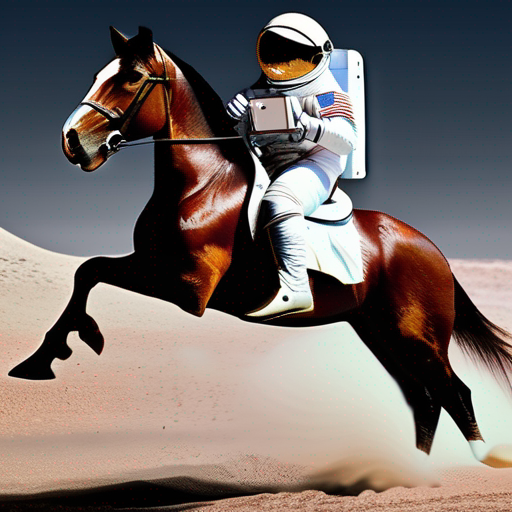

In [ ]:
prompt = "a photograph of an astronaut riding a horse."
negative_prompt = None

generator = torch.Generator("cuda").manual_seed(1)
# generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]
images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    generator=generator,
    num_inference_steps=50,
    guidance_scale=5.0,
    height=512,
    width=512,
    # add_watermarker=False,
    # num_images_per_prompt=4,
).images
# from diffusers.utils import make_image_grid
# images = make_image_grid(images, rows=2, cols=2)
display(images[0])

> 아래와 같이 prompt engineering을 진행할 수 있다.
>
> `negative_prompt`, `guidance_scale`을 바꿔가며 실험해보자.

  0%|          | 0/50 [00:00<?, ?it/s]

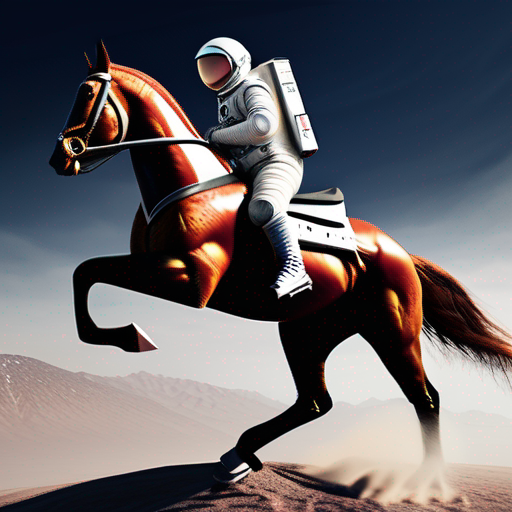

In [ ]:
prompt = "a photograph of an astronaut riding a horse."
prompt += " high quality, 4k, photorealistic, high resolution"
negative_prompt = "blur image, blurry, saturated colors, sepia image, bad quality, low resolution, watercolor, cartoonish, smooth image, oil paint, collage, multiple images, frame, border"

generator = torch.Generator("cuda").manual_seed(1)
# generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]
images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    generator=generator,
    num_inference_steps=50,
    guidance_scale=5.0,
    height=512,
    width=512,
    # add_watermarker=False,
    # num_images_per_prompt=4,
).images
# from diffusers.utils import make_image_grid
# images = make_image_grid(images, rows=2, cols=2)
display(images[0])

> 이와 같이 SD, SDXL을 활용하면 높은 퀄리티를 가진 이미지를 쉽게 생성할 수 있다.
>
> 그렇다면 일반적인 이미지를 생성하는 것이 아니라, 특정 이미지 셋에 대해서만 생성하려면 어떻게 해야할까?
>
> Prompt engineering도 좋은 방법이지만 이는 한계가 있기 때문에, 나만의 원하는 데이터셋에 대해 fine-tuning을 진행하는 경우가 많다.
>
> Stable Diffusion을 직접 fine-tuning 해보며, fine-tuning 기술 중 하나인 LoRA에 대해서 알아보자.

# Fine-tuning Stable Diffusion

## Low-Rank Adaptation (LoRA)

<!-- input image width 500 -->

### Background: Paramtet Efficient Fine-Tuning (PEFT)

> 대규모 foundation model이 등장함에 따라서 foundation model을 fine-tuning하는 방법론들의 필요성이 대두되었다.
>
> 그러나, 최근 대규모 foundation model은 parameter 수가 많아 전체 parameter를 fine-tuning을 하기 위해서는 많은 데이터와 많은 양의 컴퓨팅 자원이 필요하다.
>
> 또한, parameter 수가 많은 대규모 모델은 대규모 데이터로 학습하지 않고 적은 수의 개인화된 데이터로 학습했을 때, 기존의 모델의 parameter는 훼손되며 기존의 모델의 성능을 잃게 된다.
>
> 이에 따라 등장한 방법론이 Parameter Efficient Fine-Tuning, PEFT이다.
> PEFT는 대부분의 기존 모델의 parameter는 유지하면서 적은 수의 새로운 학습 가능한 parameter를 구성한 후 새로운 parameter만 조정하는 방법론으로,
> 기존 모델의 성능을 유지하면서 새로운 데이터셋에 맞게 parameter를 조정할 수 있다는 장점이 있다.
>
> 이에 따라서 PEFT에 대한 연구가 활발하게 이루어졌으며, 본 실습에서는 PEFT의 대표적인 방법론 중 하나인 Low-Rank Adaptation (LoRA)를 알아보고 이를 이용하여 포켓몬 이미지들을 fine-tuning 하는 방법을 알아 볼 것이다.

### Method: Low-Rank Adaptation (LoRA)

> - Hu et al. "Lora: Low-rank adaptation of large language models." ICLR 2022. [[arXiv](https://arxiv.org/abs/2106.09685)]

<img src="https://github.com/pmh9960/images/blob/main/lora.png?raw=true" width=300px>


> Low-Rank Adaptation (LoRA)는 parameter efficient하게 fine-tuning할 때, 새로운 모델의 weights는 기존 모델의 weights에 low-rank의 matrix가 더해지는 형태로 제한하였다.
>
> 즉, 변화된 모델의 weights는 기존 weights와 low-rank의 matrix로만 달라질 수 있다는 제약을 걸어준 것이다.
>
> 예를 들어, 위 그림과 같이 $W \in \mathbb{R}^{d \times d}$ 이라는 기존 모델의 weights가 있다고 가정해보자.
>
> 이 때, low-rank matrix로 제한하는 방법은 다양하게 가능하겠지만, 가장 간단한 방법은 $\Delta W = B A$ 로 만들어 주는 것이며 $A \in \mathbb{R}^{r \times d}, B \in \mathbb{R}^{d \times r}, r << d$ 로 re-parameterization을 해주면 low-rank matrix가 구성된다.
>
> 학습할 때에는 $A, B$ 만 학습되는 것이며 학습이 끝난 후에는 $W = W + \Delta W$ 로 업데이트 해주면 추가적인 inference cost가 없다는 장점이 존재한다.

## Fine-tuning with LoRA

In [ ]:
import argparse
import logging
import math
import os
import random
import shutil
from pathlib import Path

import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params, compute_snr
from diffusers.utils import check_min_version, convert_state_dict_to_diffusers, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module

args = argparse.Namespace(
    pretrained_model_name_or_path='CompVis/stable-diffusion-v1-4',
    dataset_name='lambdalabs/pokemon-blip-captions',
    output_dir="output",
    num_epochs=10,
    learning_rate=1e-4,
    batch_size=1,
    eval_prompt="a drawing of a green pokemon with red eyes.",
    mixed_precision='fp16',
    rank=4,
)

> 먼저 사전 학습된 모델을 불러오자.
>
> Stable Diffusion을 비롯한 diffusion models은 `(tokenizer, text_encoder)`, `vae`, `unet` and `noise_schedule`로 구성되어 있다.

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")

> 우리가 학습시킬 대상은 Stable Diffusion의 parameter가 아닌 새로운 LoRA의 parameter이기 때문에, `vae`, `unet`, `text_encoder`의 parameter는 `require_grad=False`로 설정해준다.

In [ ]:
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)
print('turn off grad for pretrained models')

turn off grad for pretrained models


> 이제 모델들을 gpu로 옮겨주자.
>
> - 이 때, Pre-trained model에 대해서는 GPU VRAM을 아껴주기 위해서 16-bit로 변환해주었다.

In [ ]:
weight_dtype = torch.float16 if args.mixed_precision == "fp16" else torch.float32
vae.to('cuda', dtype=weight_dtype)
unet.to('cuda', dtype=weight_dtype)
text_encoder.to('cuda', dtype=weight_dtype)
print('move models to cuda')

move models to cuda


> LoRA를 이제 설정해보자.
>
> - `r`: LoRA에서 설정해야 할 것중 가장 중요한 `rank`를 나타낸다.
>   - `rank`가 높다면 많은 parameter를 학습하기 때문에, 더 많은 GPU VRAM이 필요하고 overfitting의 여지가 있으며,
>   - `rank`가 낮다면 더 적은 parameter를 학습하기 때문에, 적은 GPU VRAM만이 필요하지만 underfitting의 여지가 있어 학습하는 데이터셋을 잘 반영하지 못할 수 있다.
>   - 이는 실험을 통해 찾아야 하는 hyper-parameter인데, 본 실습에서는 `rank=4`로 설정해주었다.
> - `lora_alpha`: $W = W + \frac{\alpha}{r} \Delta W$ 에서 $\alpha$를 나타낸다. $\frac{\alpha}{r} = 1$ 이 기본이므로 $\alpha$ 는 일반적으로 rank와 같은 값을 사용한다.
> - `init_lora_weights`: LoRA의 weights 중 $A$ 의 initialization method을 가리킨다. 일반적으로 Gaussian distribution으로 초기화한다.
> - `target_modules`: `unet`의 weights에 모두 LoRA로 적용하는 것이 아니라 일부만 적용할 수 있다. 이 때, 적용할 module을 지정해주면 된다. 본 실습에서는 `unet` 중 attention module의 weights인 `to_k`, `to_q`, `to_v`, `to_out.0`에만 LoRA를 적용해주었다.

In [ ]:
unet_lora_config = LoraConfig(
    r=args.rank,
    lora_alpha=args.rank,
    init_lora_weights='gaussian',
    target_modules=['to_k', 'to_q', 'to_v', 'to_out.0'],
)

> 이제 설정된 LoRA를 unet에 적용해주자.

In [ ]:
# unet.peft_config = {}  # if you unload_lora_weights, turn it on
unet.add_adapter(unet_lora_config, 'pokemon')
if args.mixed_precision == "fp16":
    cast_training_params(unet, dtype=torch.float32)

> Optimizer는 [AdamW](https://arxiv.org/abs/1711.05101)를 사용하였으며, optimizer에 넣어 줄 parameter는 LoRA의 parameter만 넣어줄 수 있도록 `filter` 함수를 통해 걸러주었다.

In [ ]:
lora_layers = filter(lambda p: p.requires_grad, unet.parameters())
optimizer = torch.optim.AdamW(
    lora_layers,
    lr=args.learning_rate,
    betas=(0.9, 0.999),
    weight_decay=0.01,
    eps=1e-8,
)

> **Dataset**
>
> 포켓몬 이미지와 캡션 데이터셋이 필요한데 이를 [BLIP](https://arxiv.org/abs/2201.12086)이라는 image captioning 모델을 이용하여 데이터셋이 구축되어 있다.
>
> 포켓몬 사진과 caption의 예시는 다음과 같다.
>
> - Reference: [Pokemon-blip-captions](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions)

<table>
  <tr>
    <td> <img src="https://github.com/pmh9960/images/blob/main/pokemon1.jpeg?raw=true" alt="Image 1" style="width: 300px;"/> </td>
    <td> <img src="https://github.com/pmh9960/images/blob/main/pokemon2.jpeg?raw=true" alt="Image 2" style="width: 300px;"/> </td>
    <td> <img src="https://github.com/pmh9960/images/blob/main/pokemon3.jpeg?raw=true" alt="Image 3" style="width: 300px;"/> </td>
  </tr>
  <tr>
    <td> <p style="font-size: 15px;">"a drawing of a green pokemon with red eyes"</p> </td>
    <td> <p style="font-size: 15px;">"a green and yellow toy with a red nose"</p> </td>
    <td> <p style="font-size: 15px;">"a red and white ball with an angry look on its face"</p> </td>
  </tr>
</table>

> Hugging Face 에서는 학습된 모델을 서로 공유할 수 있을 뿐 아니라 데이터셋도 서로 공유할 수 있는 서비스를 제공하고 있다.
>
> 이를 이용하여 데이터셋을 다운로드 받아보자.
>
> `datasets` 라이브러리의 `load_dataset` 함수를 이용하여 [포켓몬 데이터셋](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions)을 다운로드 받아보자.
>
> - 다운받은 데이터셋은 특별히 cache 경로를 명시하지 않으면 `~/.cache/huggingface/datasets`에 저장됩니다.

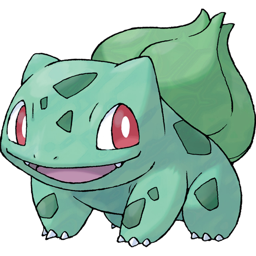

a drawing of a green pokemon with red eyes


In [ ]:
dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = dataset[0]
display(sample["image"].resize((256, 256)))
print(sample["text"])

> 이제 이 데이터셋으로부터 image와 caption을 전처리하는 함수를 만들어보자.

In [ ]:
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples['text']:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # 몇 가지 caption 중 하나를 고르게 할 수도 있음.
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(f"Caption column should contain either strings or lists of strings.")
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids


# 이미지 전처리 함수
train_transforms = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])


def preprocess_train(examples):
    images = [image.convert('RGB') for image in examples["image"]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

> 전처리가 잘 되었는지 확인해보자.

In [ ]:
samples = dataset[0:2] # 첫 두 샘플을 배치로 묶어 확인해보자.
preprocessed_samples = preprocess_train(samples)
print('pixel_values:', torch.stack(preprocessed_samples['pixel_values']).shape)
print('input_ids:', preprocessed_samples['input_ids'].shape)

pixel_values: torch.Size([2, 3, 256, 256])
input_ids: torch.Size([2, 77])


> 전처리 함수를 `dataset`에 적용시키고, dataloader를 구축하면 다음과 같다.
>
> `collate_fn`은 batch 단위로 데이터를 처리하는 함수로 지금은 dictionary 형태로 출력하는 sample들을 하나씩 모아서 새로운 dictionary로 구축할 수 있도록 한다.

In [ ]:
train_dataset = dataset.with_transform(preprocess_train)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

> 이제 학습을 시작해보자.

In [ ]:
pbar = tqdm(total=args.num_epochs * len(train_dataloader), desc="Training")
for epoch in range(args.num_epochs):
    unet.train()
    for step, batch in enumerate(train_dataloader):
        # VAE를 통해 latent로 encoding
        latents = vae.encode(batch["pixel_values"].to('cuda', dtype=weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        # Diffusion model의 objective인 Gaussian noise를 sample (epsilon prediction)
        noise = torch.randn_like(latents)

        bsz = latents.shape[0]  # batch size
        # 얼마나 noise를 뿌릴지 결정하는 timesteps를 uniformly random하게 선택
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device, dtype=torch.long)
        # scheduler에 따라서 noise를 추가함.
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # text encoder를 통해 caption을 encoding
        encoder_hidden_states = text_encoder(batch["input_ids"].to('cuda'), return_dict=False)[0]

        # Diffusion model의 objective는 처음 추가된 noise (epsilon)
        target = noise

        # UNet을 통해 예측된 noise (epsilon)
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

        # Loss 계산
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})

    # # 아래 두 break의 주석을 풀어서 pixel_values와 input_ids, latents 등을 확인해보자.
    #     break
    # break


Training:   0%|          | 0/8330 [00:00<?, ?it/s]

> 이제 학습된 LoRA 가중치를 저장해보자.
>
> Diffusers library의 `save_lora_weights` 함수를 이용하여 저장할 수 있다.

In [ ]:
# save lora weights
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet, adapter_name='pokemon'))
StableDiffusionPipeline.save_lora_weights(
    save_directory='output',
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

## Inference with LoRA

> 이제 저장된 LoRA 가중치를 불러와서 inference를 해보자.
>
> 추가 학습이 없었던 모델과 비교하며 어떤 차이가 있는지 확인해보자.
>
> Inference는 앞서 보았던 것 처럼 diffusers의 `DiffusionPipeline`을 이용하면 쉽게 할 수 있다.

In [ ]:
# 학습된 unet을 diffusers의 DiffusionPipeline의 형태로 불러온다.
pipe = DiffusionPipeline.from_pretrained(
    args.pretrained_model_name_or_path,
    unet=unet,
    torch_dtype=weight_dtype,
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

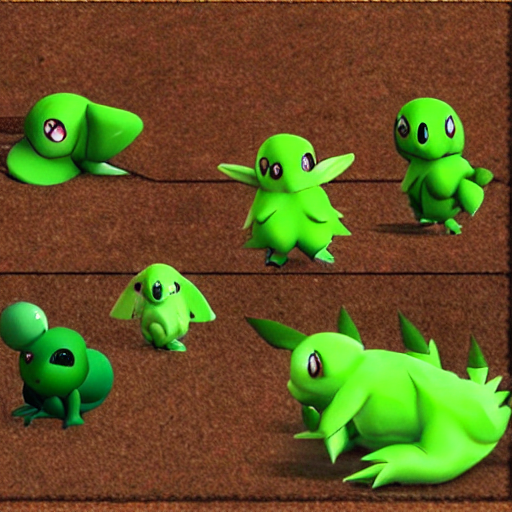

In [ ]:
# LoRA weights가 없는 상황에서의 inference 결과
pipe.unload_lora_weights()
image = pipe(
    "Green pokemon with menacing face.",
    num_inference_steps=25,
    guidance_scale=5.0,
    generator=torch.Generator("cuda").manual_seed(1),
).images[0]
display(image)

  0%|          | 0/25 [00:00<?, ?it/s]

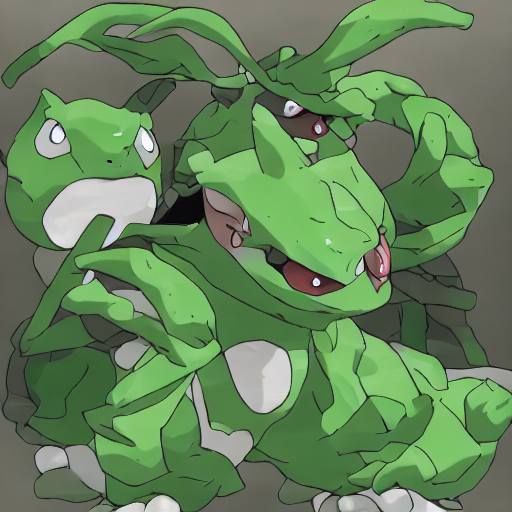

: 

In [ ]:
# 본 학습 과정을 통해서 얻은 LoRA weights를 불러와서 inference 한 결과
pipe.unload_lora_weights()
pipe.load_lora_weights('output/pytorch_lora_weights.safetensors', 'pokemon')

image = pipe(
    "Green pokemon with menacing face.",
    num_inference_steps=25,
    guidance_scale=5.0,
    generator=torch.Generator("cuda").manual_seed(1),
).images[0]
display(image)

> 본 실습에서는 설명을 위해 최소한의 train code만을 이용하여 학습을 진행하였다.
>
> Logging, checkpointing, early stopping, learning rate scheduling 등의 기능들은 생략되었으나 실제로 학습을 진행할 때에는 이러한 기능들을 이용하여 학습을 진행하는 것이 좋다.
>
> 더 많은 학습 트릭이 포함되어 있는 전체 학습 코드는 Diffusers에서 제공하는 예시 중 하나인 [examples/text_to_image](https://github.com/huggingface/diffusers/tree/main/examples/text_to_image) 에서 확인할 수 있다.
>
> 그리고 아래는 해당 학습 코드를 이용하여 학습한 LoRA 가중치를 이용하여 inference를 진행한 결과이다.

  0%|          | 0/25 [00:00<?, ?it/s]

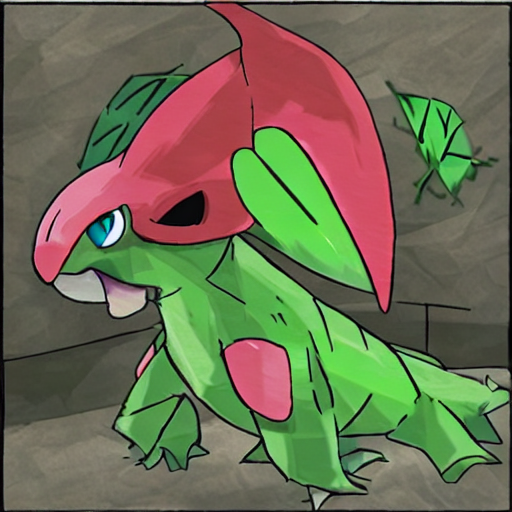

In [ ]:
# 여러 학습 테크닉을 사용하여 학습된 LoRA weights를 불러와서 inference 한 결과
lora_model_id = "sayakpaul/sd-model-finetuned-lora-t4"

pipe.unload_lora_weights()
pipe.load_lora_weights(lora_model_id, 'pokemon')
image = pipe(
    "Green pokemon with menacing face.",
    num_inference_steps=25,
    guidance_scale=5.0,
    generator=torch.Generator("cuda").manual_seed(1),
).images[0]
display(image)